In [1]:
import os
import gdown
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
files_to_download = [
    {'id': '1XP7aWc8AqALFA5HofiC6FQOI5rJ6SVc9', 'name': 'Dataset.zip'},
    {'id': '1pzknl3RgnAmMEutPoKJ0iiPcDepDAN8y', 'name': 'idm_baru.csv'}
]

def download_file(file_id, output_file):
    download_url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(download_url, output_file, quiet=False)

for file in files_to_download:
    download_file(file['id'], file['name'])

with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall("Data/")


In [2]:
day_path = 'Data/Dataset/Daylight'
night_path = 'Data/Dataset/NTL'
metadata = 'Data/idm_baru.csv'

In [3]:
idm_df = pd.read_csv(metadata)
idm_df.head()

,KABUPATEN,KECAMATAN,KODE BPS,DESA,IKS,IKE,IKL,IDM,KATEGORI IDM,BINARY STATUS
0,ACEH UTARA,SAWANG,1111010001,RISEH TUNONG,0.56,3667.00,3333.0,0.42,SANGAT TERTINGGAL,TERTINGGAL
1,ACEH UTARA,SAWANG,1111010002,GUNCI,7029.00,4167.00,3333.0,4843.00,SANGAT TERTINGGAL,TERTINGGAL
2,ACEH UTARA,SAWANG,1111010003,KUBU,6914.00,4667.00,4667.0,5416.00,TERTINGGAL,TERTINGGAL
3,ACEH UTARA,SAWANG,1111010004,BLANG CUT,6514.00,3333.00,4667.0,4838.00,SANGAT TERTINGGAL,TERTINGGAL
4,ACEH UTARA,SAWANG,1111010005,RISEH TEUNGOH,5714.00,0.45,5333.0,5183.00,TERTINGGAL,TERTINGGAL


In [4]:
idm_df_filtered = idm_df[['KODE BPS', 'KECAMATAN', 'DESA', 'BINARY STATUS']]
idm_df_filtered

,KODE BPS,KECAMATAN,DESA,BINARY STATUS
0,1111010001,SAWANG,RISEH TUNONG,TERTINGGAL
1,1111010002,SAWANG,GUNCI,TERTINGGAL
2,1111010003,SAWANG,KUBU,TERTINGGAL
3,1111010004,SAWANG,BLANG CUT,TERTINGGAL
4,1111010005,SAWANG,RISEH TEUNGOH,TERTINGGAL
...,...,...,...,...
846,1111041003,GEUREDONG PASE,KRUENG MBANG,TERTINGGAL
847,1111041002,GEUREDONG PASE,PULO MEURIA,TERTINGGAL
848,1111041001,GEUREDONG PASE,SUKA DAMAI,MAJU
849,1111022002,BANDA BARO,ALUE KEURINYAI,MAJU


In [5]:
def match_images_with_metadata(image_files, metadata, is_night=False):
    image_data = []
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        if is_night:
            village_code = img_name.split('.')[0]
        else:
            village_code = img_name.split('-')[0]
        village_info = metadata[metadata['KODE BPS'] == int(village_code)]
        if not village_info.empty:
            kecamatan = village_info['KECAMATAN'].values[0]
            desa = village_info['DESA'].values[0]
            status = village_info['BINARY STATUS'].values[0]
            image_data.append({
                'id' : village_code,
                'filename': img_name,
                'filepath': img_path,
                'kecamatan': kecamatan,
                'desa': desa,
                'status': status
            })
    return pd.DataFrame(image_data)

In [6]:
day_files = [os.path.join(root, file) for root, _, files in os.walk(day_path) for file in files]
night_files = [os.path.join(root, file) for root, _, files in os.walk(night_path) for file in files]

day_images_metadata = match_images_with_metadata(day_files, idm_df_filtered)
night_images_metadata = match_images_with_metadata(night_files, idm_df_filtered, is_night=True)

In [8]:
day_images_metadata.head()

,id,filename,filepath,kecamatan,desa,status
0,1111010008,1111010008-l.png,Data/Dataset/Daylight\MAJU\1111010008-l.png,SAWANG,SAWANG,MAJU
1,1111010008,1111010008-s.png,Data/Dataset/Daylight\MAJU\1111010008-s.png,SAWANG,SAWANG,MAJU
2,1111010023,1111010023-l.png,Data/Dataset/Daylight\MAJU\1111010023-l.png,SAWANG,MEUNASAH PULO,MAJU
3,1111010023,1111010023-s.png,Data/Dataset/Daylight\MAJU\1111010023-s.png,SAWANG,MEUNASAH PULO,MAJU
4,1111010024,1111010024-l.png,Data/Dataset/Daylight\MAJU\1111010024-l.png,SAWANG,LHOK KUYUN,MAJU


In [9]:
night_images_metadata.head()

,id,filename,filepath,kecamatan,desa,status
0,1111010008,1111010008.png,Data/Dataset/NTL\MAJU\1111010008.png,SAWANG,SAWANG,MAJU
1,1111010023,1111010023.png,Data/Dataset/NTL\MAJU\1111010023.png,SAWANG,MEUNASAH PULO,MAJU
2,1111010024,1111010024.png,Data/Dataset/NTL\MAJU\1111010024.png,SAWANG,LHOK KUYUN,MAJU
3,1111010027,1111010027.png,Data/Dataset/NTL\MAJU\1111010027.png,SAWANG,BABAH BULOH,MAJU
4,1111010034,1111010034.png,Data/Dataset/NTL\MAJU\1111010034.png,SAWANG,ULEE GEUDONG,MAJU


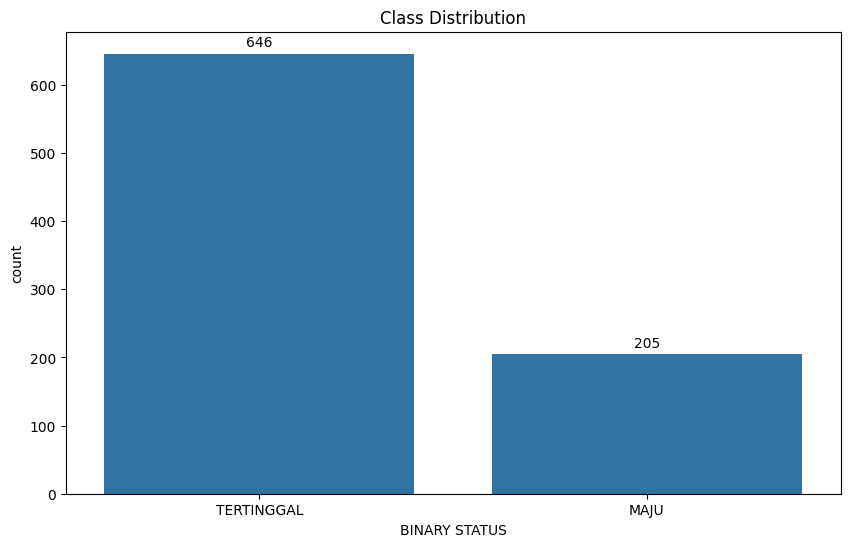

In [10]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='BINARY STATUS', data=idm_df_filtered)
plt.title('Class Distribution')
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

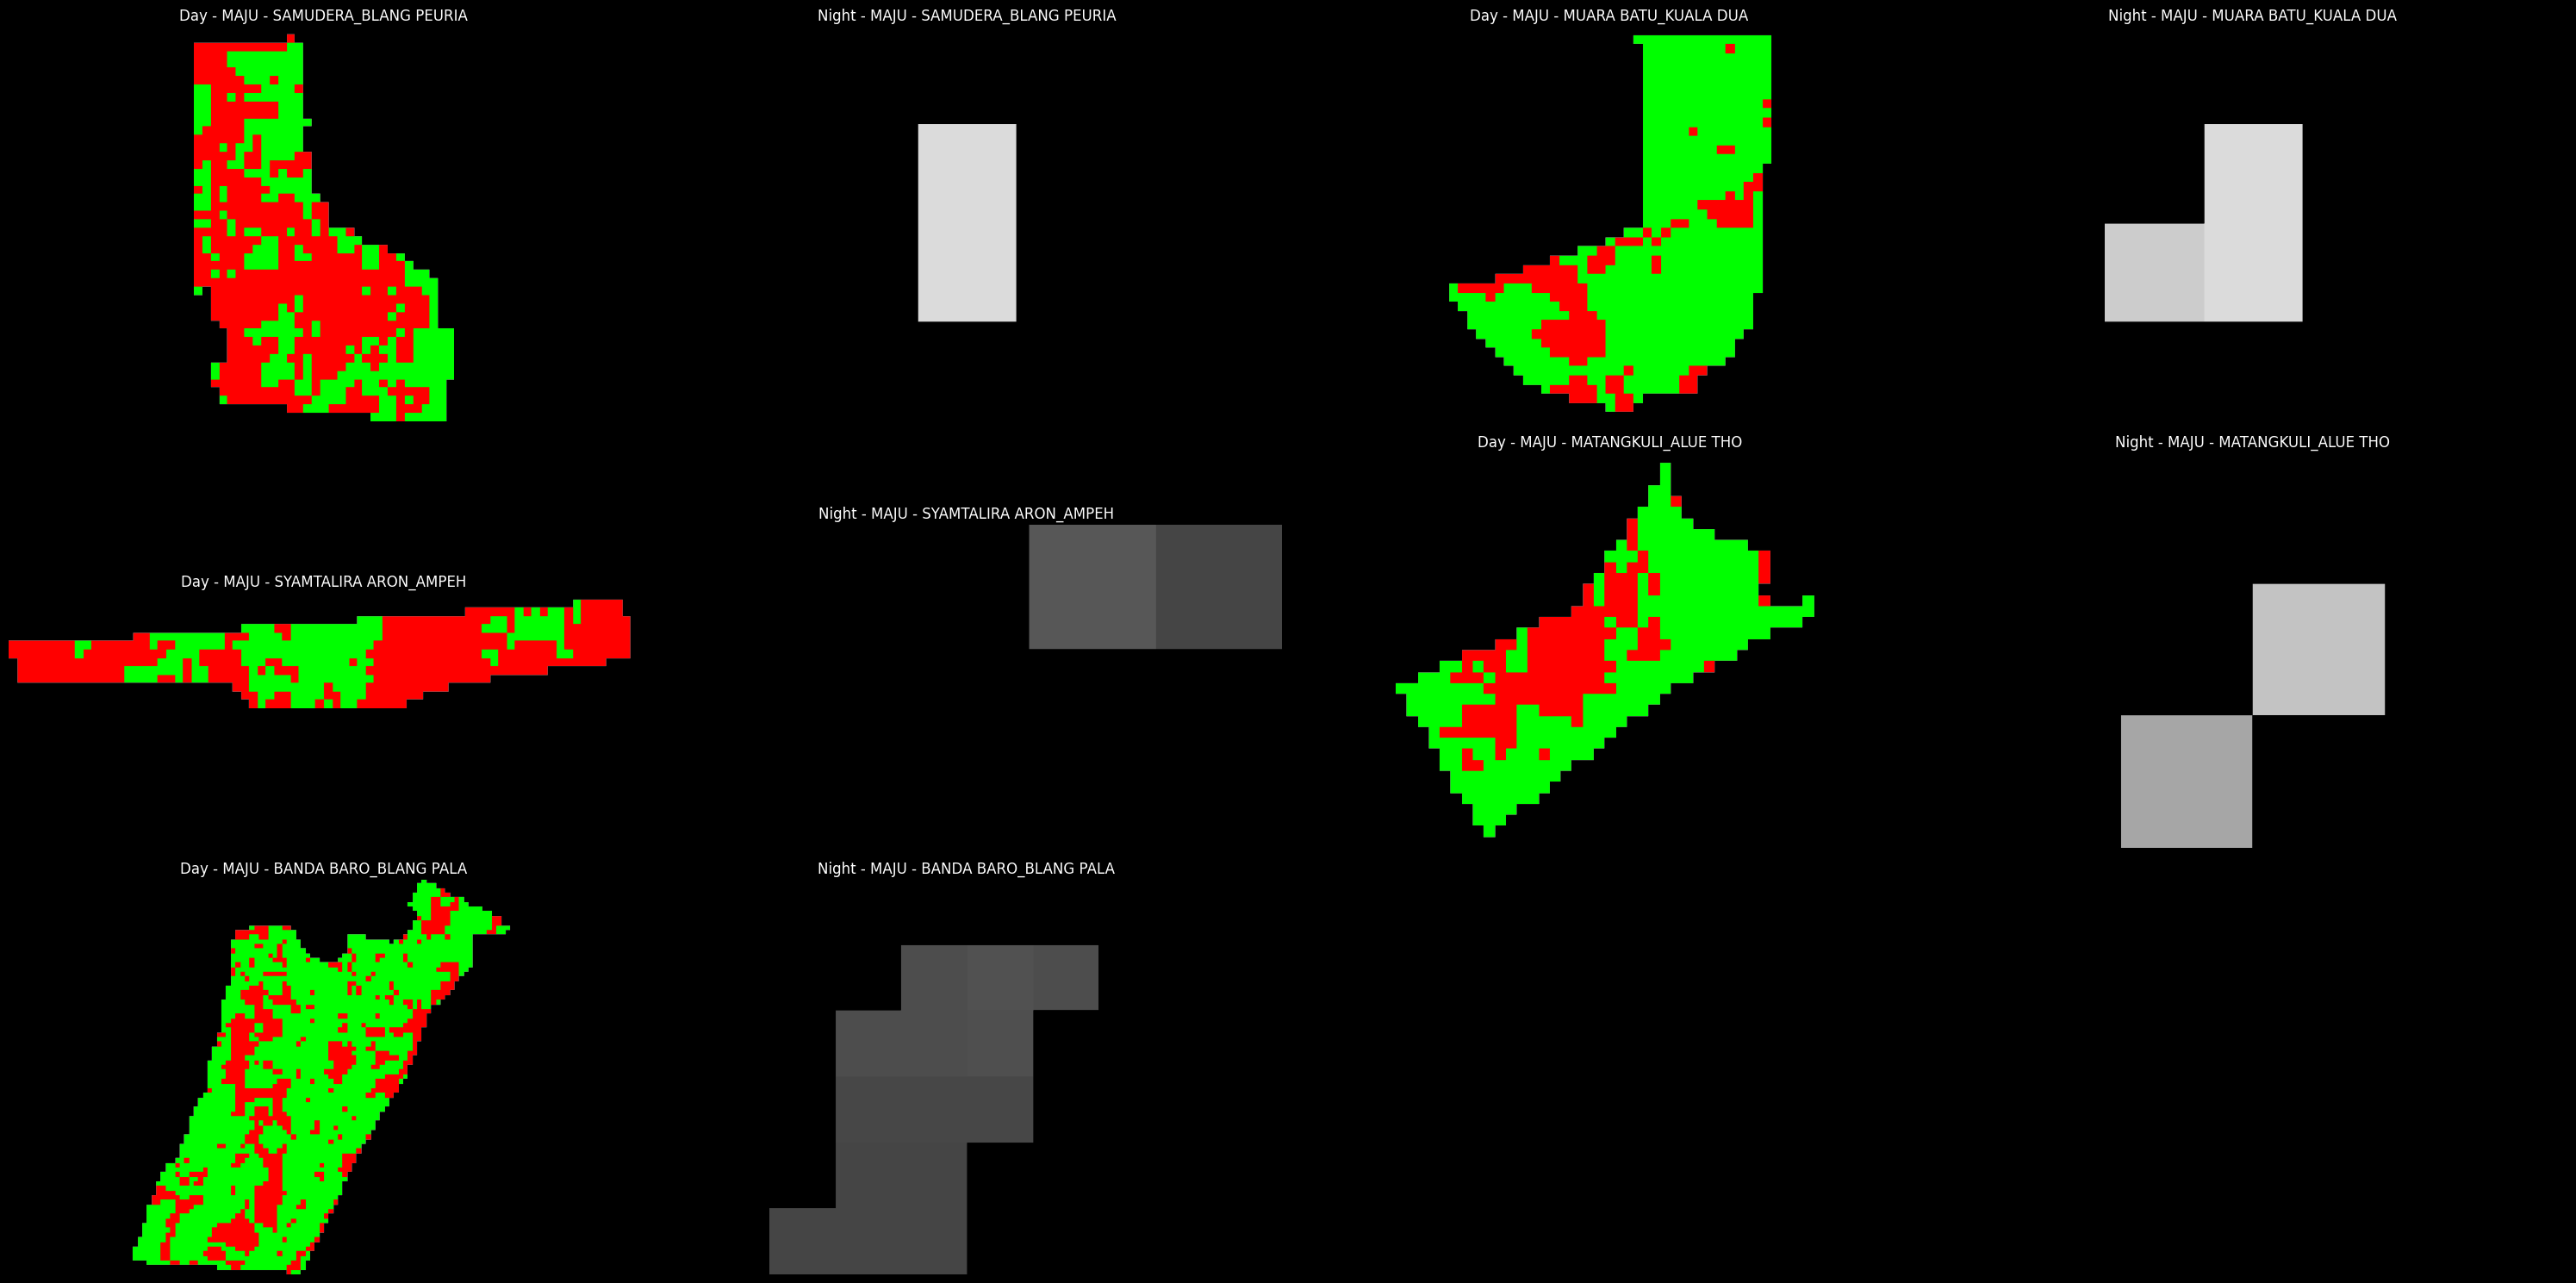

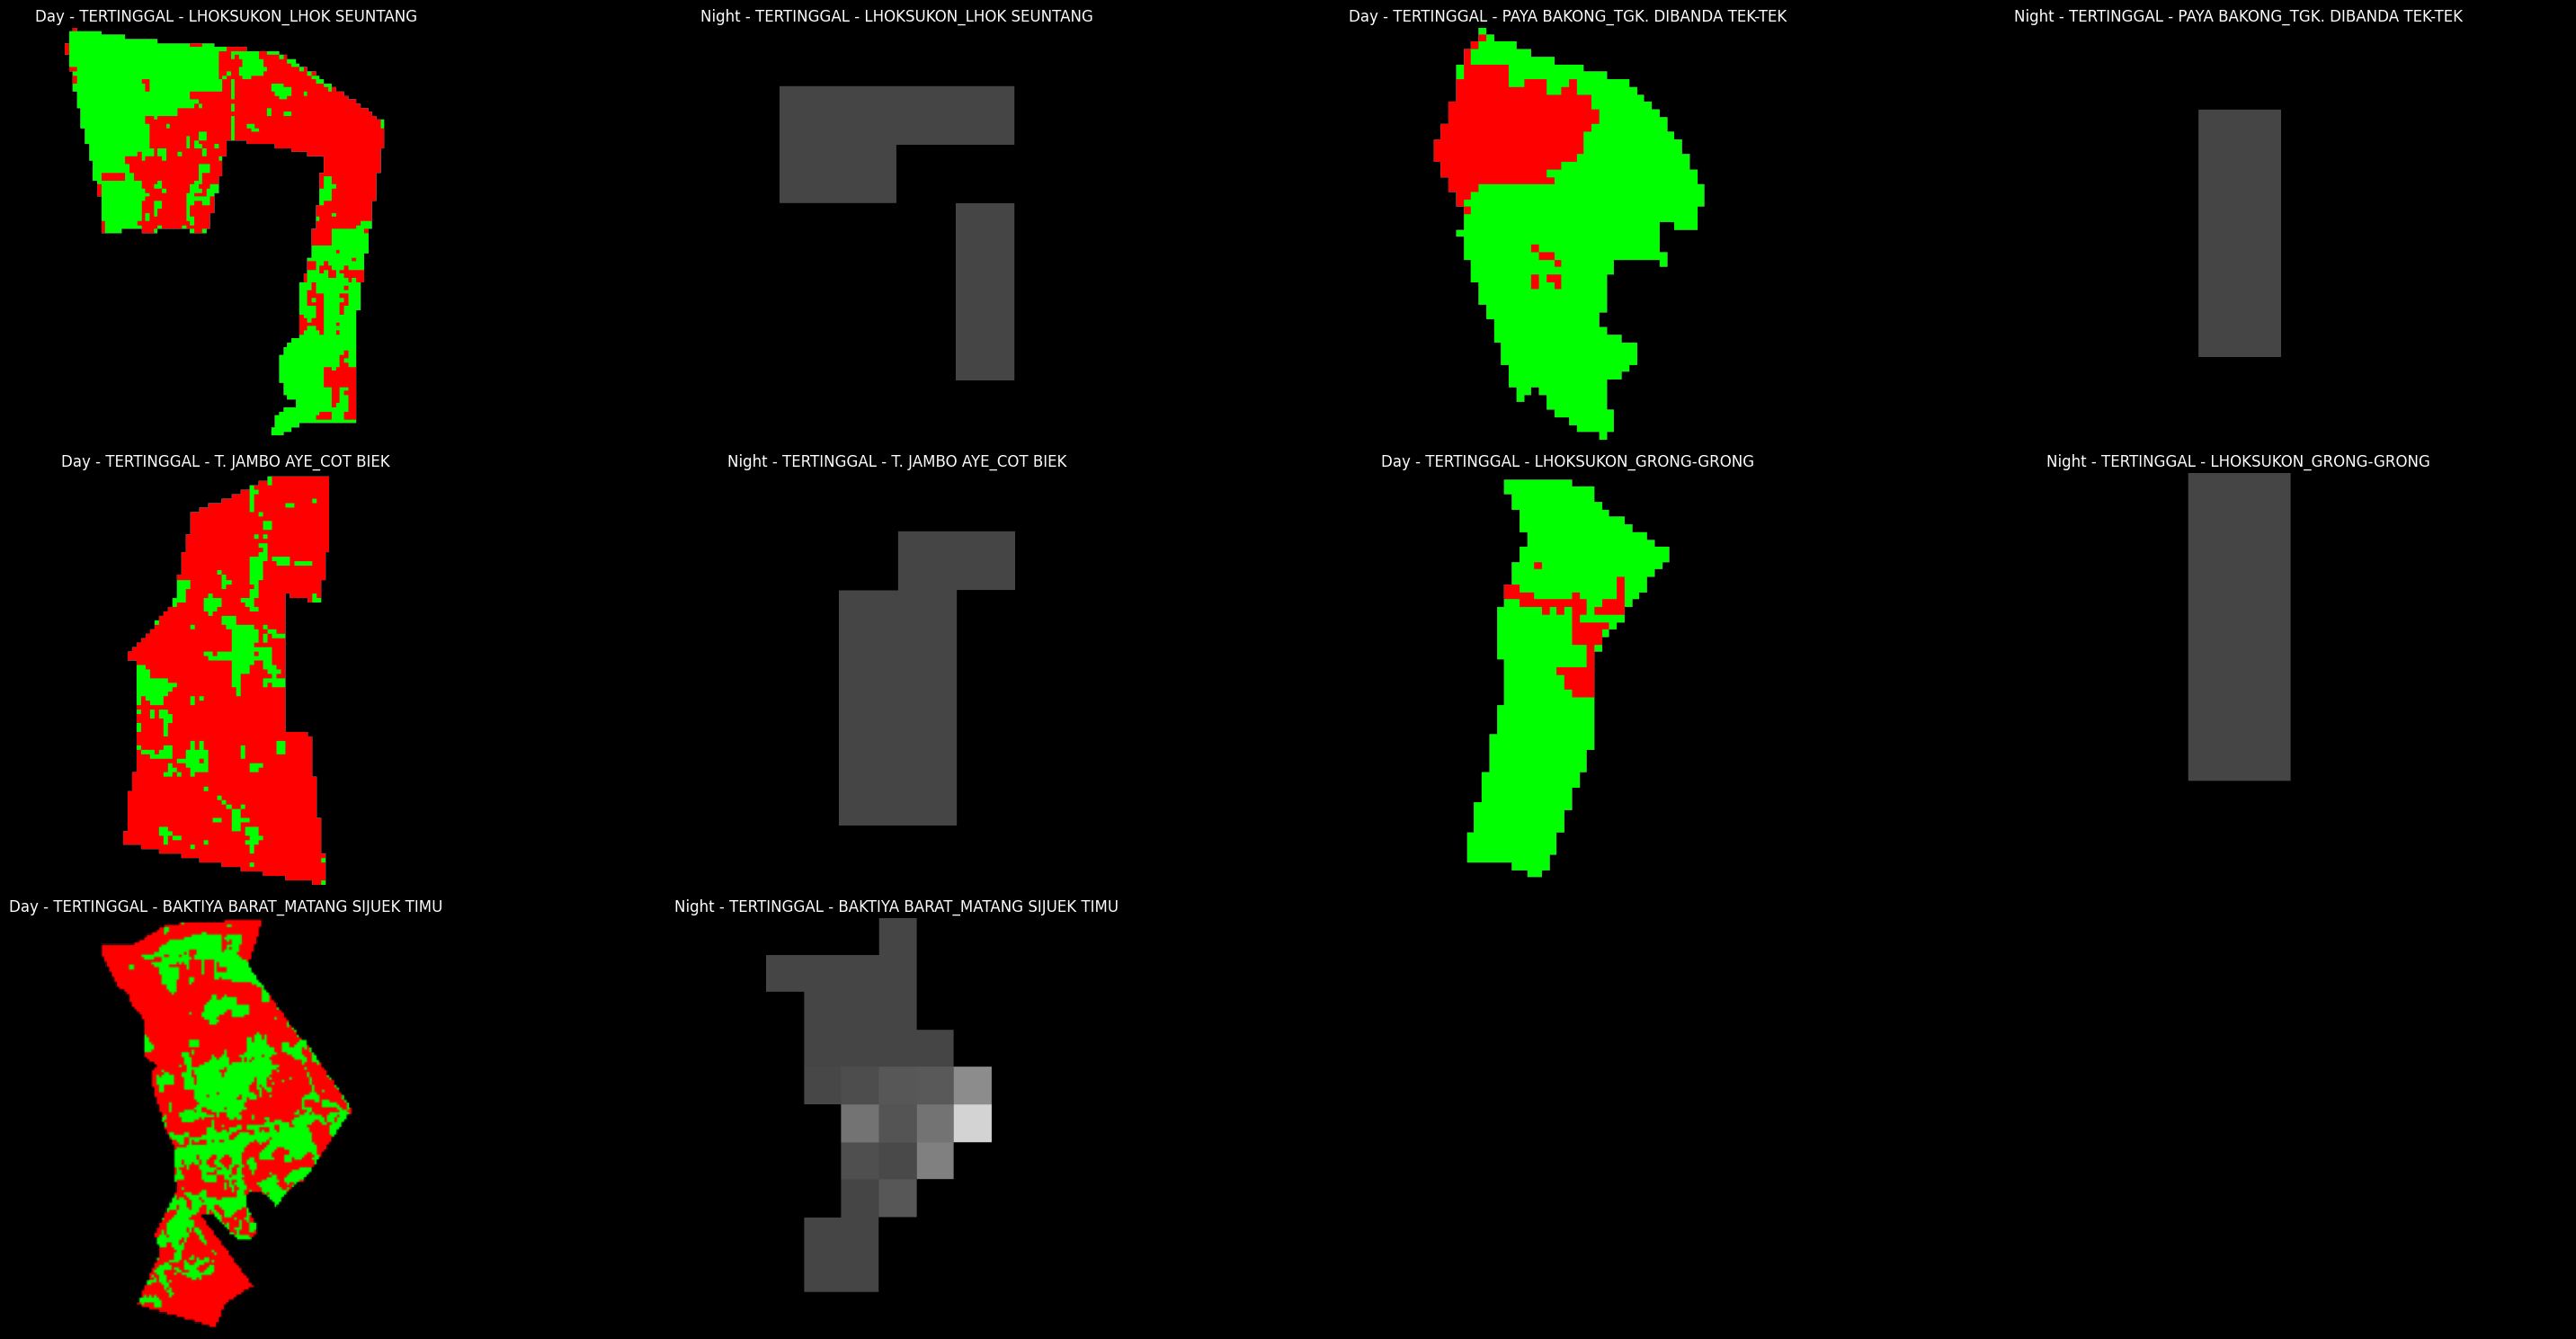

In [13]:
def show_sample_images(day_image_data, night_image_data, class_label, n=5, cols=2):
    class_images_day = day_image_data[day_image_data['status'] == class_label]
    class_images_night = night_image_data[night_image_data['status'] == class_label]
    
    common_villages = pd.merge(class_images_day, class_images_night, on='id')
    sample_villages = common_villages.sample(n)
    
    rows = (n // cols) + (n % cols > 0)
    fig, axes = plt.subplots(rows, cols*2, figsize=(30, 5*rows))
    fig.patch.set_facecolor('black')
    axes = axes.flatten()
    
    for i, (_, village_row) in enumerate(sample_villages.iterrows()):
        # Day images
        img_path_day = village_row['filepath_x']
        img_day = Image.open(img_path_day)
        ax_day = axes[i*2]
        ax_day.imshow(img_day)
        ax_day.set_title(f"Day - {class_label} - {village_row['kecamatan_x']}_{village_row['desa_x']}", color='white')
        ax_day.axis('off')
        ax_day.set_facecolor('black')
        
        # Night images
        img_path_night = village_row['filepath_y']
        img_night = Image.open(img_path_night)
        ax_night = axes[i*2 + 1]
        ax_night.imshow(img_night)
        ax_night.set_title(f"Night - {class_label} - {village_row['kecamatan_y']}_{village_row['desa_y']}", color='white')
        ax_night.axis('off')
        ax_night.set_facecolor('black')
    
    for ax in axes[len(sample_villages)*2:]:
        ax.axis('off')
        ax.set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

show_sample_images(day_images_metadata, night_images_metadata, 'MAJU', n=5, cols=2)
show_sample_images(day_images_metadata, night_images_metadata, 'TERTINGGAL', n=5, cols=2)

In [14]:
def normalize_path(path):
    return os.path.normpath(path)

def normalize_paths(df, path_column):
    df[path_column] = df[path_column].apply(normalize_path)
    return df

day_images_metadata = normalize_paths(day_images_metadata, 'filepath')
night_images_metadata = normalize_paths(night_images_metadata, 'filepath')

In [16]:
night_images_metadata

,id,filename,filepath,kecamatan,desa,status
0,1111010008,1111010008.png,Data\Dataset\NTL\MAJU\1111010008.png,SAWANG,SAWANG,MAJU
1,1111010023,1111010023.png,Data\Dataset\NTL\MAJU\1111010023.png,SAWANG,MEUNASAH PULO,MAJU
2,1111010024,1111010024.png,Data\Dataset\NTL\MAJU\1111010024.png,SAWANG,LHOK KUYUN,MAJU
3,1111010027,1111010027.png,Data\Dataset\NTL\MAJU\1111010027.png,SAWANG,BABAH BULOH,MAJU
4,1111010034,1111010034.png,Data\Dataset\NTL\MAJU\1111010034.png,SAWANG,ULEE GEUDONG,MAJU
...,...,...,...,...,...,...
846,1111170008,1111170008.png,Data\Dataset\NTL\TERTINGGAL\1111170008.png,DEWANTARA,ULEE REULEUNG,TERTINGGAL
847,1111170009,1111170009.png,Data\Dataset\NTL\TERTINGGAL\1111170009.png,DEWANTARA,LANCANG BARAT,TERTINGGAL
848,1111170010,1111170010.png,Data\Dataset\NTL\TERTINGGAL\1111170010.png,DEWANTARA,GEULUMPANG SULU BARAT,TERTINGGAL
849,1111170014,1111170014.png,Data\Dataset\NTL\TERTINGGAL\1111170014.png,DEWANTARA,BANGKA JAYA,TERTINGGAL
